# Georgian Digital Alphabet Recognition

### Preprocessing
add useful imports

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

turns a number to a one hot array

In [11]:
def to_one_hot(values: np.ndarray, max: int) -> np.matrix:
    one_hot = np.zeros((values.size, max))
    rows = np.arange(values.size)
    one_hot[rows, values] = 1    

    return one_hot

import image data and convert images to numpy arrays

In [12]:
import matplotlib.image as im

X_arr = list[np.ndarray]()
Y_arr = list[int]()
num_chars = ord("ჰ") - ord("ა")

for i in range(num_chars):
    char = chr(ord("ა") + i)

    file_path = f"data/images/{char}"
    for image in os.listdir(file_path):
        img_data = im.imread(f"{file_path}/{image}").ravel()

        X_arr.append(np.append(img_data, np.ones(10000 - len(img_data))))
        Y_arr.append(i)

turn list of image values to numpy matrix, values to one_hot vector

In [13]:
X = np.asmatrix(X_arr)
Y = to_one_hot(np.asarray(Y_arr), num_chars)

X.shape, Y.shape

((28160, 10000), (28160, 32))

divide data to train, validation, and test

In [14]:
division_points = (int(X.shape[0] * 0.6), int(X.shape[0] * 0.8))

data = np.append(X, Y, 1)
np.random.shuffle(data)

X = data[:, 0: X.shape[1]]
Y = data[:, X.shape[1]:]

X_train = X[0: division_points[0], :]
Y_train = Y[0: division_points[0], :]

X_valid = X[division_points[0]: division_points[1], :]
Y_valid = Y[division_points[0]: division_points[1], :]

X_test = X[division_points[1]:, :]
Y_test = Y[division_points[1]:, :]

X_train.shape, X_valid.shape, X_test.shape

((16896, 10000), (5632, 10000), (5632, 10000))

add normalizarion to the three datas seperately

In [15]:
X_train -= X_train.mean(0)
X_valid -= X_valid.mean(0)
X_test -= X_test.mean(0)

#### Reduce dimensions using PCA for data compression reasons
find minimum dimension to reduce data to

In [16]:
min_dimension = 0

sigma = (1 / X_train.shape[0]) * X.T * X
u, s, _ = np.linalg.svd(sigma)

dimension_sum = 0
full_sum = np.sum(s)

for k in range(len(s)):
    dimension_sum += s[k]
    variance_retained = dimension_sum / full_sum

    if variance_retained > 0.99:
        min_dimension = k
        break

In [17]:
min_dimension

1902

reduce data

In [18]:
u_reduce = u[:, : min_dimension]

X_train = X_train * u_reduce
X_valid = X_valid * u_reduce
X_test = X_test * u_reduce

X_train.shape, X_valid.shape, X_test.shape

((16896, 1902), (5632, 1902), (5632, 1902))

### Define neural network model class

In [41]:
class NeuralNetworkModel:
    def __init__(self, in_size: int, out_size: int, hidden_sizes: list[int]) -> None:
        self.layers: list[int] = [in_size] + hidden_sizes + [out_size]
        
        self.thetas = list[np.matrix]()
        self.biases = list[np.matrix]()

        for i in range(len(self.layers) - 1):
            prev_size: int = self.layers[i]
            next_size: int = self.layers[i + 1]

            # for large inputs dividing by the sqrt of the size helps to keep weight and layer values low
            self.thetas.append(np.asmatrix(np.random.standard_normal((next_size, prev_size)) / np.sqrt(in_size)))
            self.biases.append(np.asmatrix(np.random.standard_normal((next_size, 1))))

    def __ReLU(self, X: np.matrix) -> np.matrix:
        return np.maximum(0, X)

    def __ReLU_grad(self, X: np.matrix) -> np.matrix:
        return np.where(X <= 0, 0, 1)

    def __sigmoid(self, X: np.matrix) -> np.matrix:
        ephsilon = 1e-5 # to avoid returning 1
        X = X.clip(-500, 500) # to prevent overflows

        return np.divide(1, 1 + np.exp(-X) + ephsilon)

    def __forward(self, input: np.matrix, thetas: list[np.matrix]) -> tuple[np.matrix, list[np.matrix]]:
        result: np.matrix = input
        layer_values: list[np.matrix] = [input]

        for i in range(len(self.layers) - 1):
            # z(i)
            result = np.dot(result, thetas[i].T)
            result = np.add(result, self.biases[i].T)
            # a(i)
            if i != len(self.layers) - 2: 
                result = self.__ReLU(result)
                layer_values.append(result)

            else: result = self.__sigmoid(result)

        return result, layer_values

    # forward propagation, but returns array with only 1 and 0s
    def predict(self, input: np.matrix) -> np.matrix:
        # predictions =
        return self.__forward(input, self.thetas)
        # return to_one_hot(np.asarray(predictions.argmax(axis=1)).ravel(), num_chars)

    def cost(self, X: np.matrix, Y: np.matrix, lambd: float, thetas: list[np.matrix]) -> float:
        h, _ = self.__forward(X, thetas)

        # compute cost
        first_term = np.multiply(Y, np.log(h))
        second_term = np.multiply((1 - Y), np.log(1 - h))
        J = np.sum(first_term + second_term) / (-X.shape[0])

        # add regularization
        regularized = 0
        for thetas in thetas:
            regularized += np.sum(np.power(thetas, 2)) * (lambd / (2 * X.shape[0]))

        J += regularized

        return J
    
    # backpropagation
    def gradients(self, X: np.matrix, Y: np.matrix, lambd: float) -> tuple[list[np.matrix], list[np.matrix]]:
        m = X.shape[0]

        h, a_values = self.__forward(X, self.thetas)
        bias_a = [np.ones((m, 1)) for _ in a_values]

        grads = [np.zeros(theta.shape) for theta in self.thetas]
        biases = [np.zeros(bias.shape) for bias in self.biases]

        # last layer gradients
        last_delta = h - Y
        grads[-1] = np.dot(last_delta.T, a_values[-1]) / m
        grads[-1] += (lambd * self.thetas[-1]) / m  # regulatization

        biases[-1] = np.dot(last_delta.T, bias_a[-1]) / m

        # hidden layer gradients
        for i in reversed(range(1, len(a_values))):
            delta = np.multiply(np.dot(last_delta, self.thetas[i]), self.__ReLU_grad(a_values[i]))
            last_delta = delta

            grads[i - 1] = np.dot(delta.T, a_values[i - 1]) / m
            grads[i - 1] += (lambd * self.thetas[i - 1]) / m   # regulatization

            biases[i - 1] = np.dot(delta.T, bias_a[i - 1]) / m

        return grads, biases

    def gradient_check(self, X: np.matrix, Y: np.matrix, lambd: float, grads: list[np.matrix]) -> bool:
        ephsilon = 1e-8
        
        new_theta1 = [np.copy(theta) for theta in self.thetas]
        new_theta2 = [np.copy(theta) for theta in self.thetas]
        preds = [np.zeros(grad.shape) for grad in grads]
        for l in range(len(self.thetas)):
            for i in range(self.thetas[l].shape[0]):
                for j in range(self.thetas[l].shape[1]):
                    new_theta1[l][i, j] = new_theta1[l][i, j] + ephsilon
                    new_theta2[l][i, j] = new_theta2[l][i, j] - ephsilon

                    grad_pred = self.cost(X, Y, lambd, new_theta1) - self.cost(X, Y, lambd, [theta for theta in new_theta2])
                    grad_pred = grad_pred / (2 * ephsilon)
                    preds[l][i, j] = grad_pred

                    new_theta1[l][i, j] = new_theta1[l][i, j] - ephsilon
                    new_theta2[l][i, j] = new_theta2[l][i, j] + ephsilon

        flattened_grads = np.concatenate([np.asarray(grad).ravel() for grad in grads])
        flattened_preds = np.concatenate([np.asarray(pred).ravel() for pred in preds])

        numerator = np.linalg.norm(flattened_grads - flattened_preds)
        denominator = np.linalg.norm(flattened_grads) + np.linalg.norm(flattened_preds)
        diff = numerator / denominator

        if diff > 1e-4:
            print(diff)
            print(grads) 
            print(preds)
            return False

        return True

    def train(self, X: np.matrix, Y: np.matrix, alpha: float, lambd: float, max_iters: int = 1000) -> np.ndarray:
        cost = np.zeros(max_iters)

        for i in range(max_iters):
            theta_grads, bias_grads = self.gradients(X, Y, lambd)

            # assert self.gradient_check(X, Y, lambd, theta_grads)

            for j, _ in enumerate(self.thetas):
                self.thetas[j] = self.thetas[j] - np.multiply(alpha, theta_grads[j])
                self.biases[j] = self.biases[j] - np.multiply(alpha, bias_grads[j])

            cost[i] = self.cost(X, Y, lambd, self.thetas)

        return cost

### Build a model

In [42]:
nn = NeuralNetworkModel(min_dimension, num_chars, [256, 256, 256])

In [43]:
cost = nn.train(X_train, Y_train, 0.01, 0.1, 100)

In [37]:
cost

array([483.71931005, 248.23252941, 299.0897483 , 164.9670367 ,
       115.05450566,  86.95498281,  72.57874406,  63.07960315,
        56.83461927,  51.78633279,  47.78678482,  44.49881608,
        41.71154014,  39.29916756,  37.16082823,  35.21110391,
        33.4113442 ,  31.75537007,  30.22129309,  28.76687154,
        27.40885829,  26.13379054,  24.93755866,  23.81611377,
        22.75722899,  21.768016  ,  20.84306566,  19.97887154,
        19.17048304,  18.41756724,  17.70763965,  17.0350812 ,
        16.39813242,  15.78159139,  15.19377137,  14.63070255,
        14.09935699,  13.58688086,  13.09520515,  12.62016665,
        12.16996374,  11.7423301 ,  11.3441904 ,  10.97653921,
        10.63053512,  10.30950477,  10.00430379,   9.71914536,
         9.44851875,   9.19788715,   8.96385478,   8.7492205 ,
         8.54765034,   8.3610537 ,   8.18553112,   8.0272146 ,
         7.87669728,   7.75277149,   7.63106202,   7.56422387,
         7.46099617,   7.47922781,   7.30184778,   7.38

draw the graph of model costs to choose the best alpha

Text(0.5, 1.0, 'Error vs. Training Epoch')

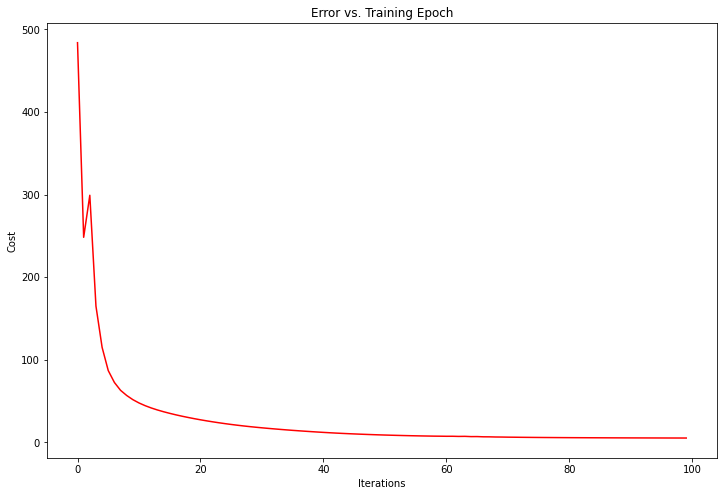

In [38]:
vfig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(cost.size), cost, 'r')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Error vs. Training Epoch')

In [5]:
whaat = np.asmatrix([
    im.imread(f"data/images/ა/1_aacadhn.ttf_fs_24_bc_256.ა.png").ravel(),
    im.imread(f"data/images/ც/132_aacadhn.ttf_fs_40_bc_256.ც.png").ravel(),
    np.zeros(10000)
])

In [35]:
nn.predict(whaat)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])